Code for the figures, where an image is restored from a fraction of pixels (fig. 7 bottom, fig. 14 of supmat).

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/deep-image-prior')

Mounted at /content/drive


In [ ]:
"""
*Uncomment if running on colab*
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab
"""
# !git clone https://github.com/DmitryUlyanov/deep-image-prior
# !mv deep-image-prior/* ./

# Import libs

In [3]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
from models import get_net
import torch
import torch.optim
from skimage.metrics import peak_signal_noise_ratio as compare_psnr

from utils.inpainting_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize=-1
dim_div_by = 64
dtype = torch.cuda.FloatTensor

# Choose figure

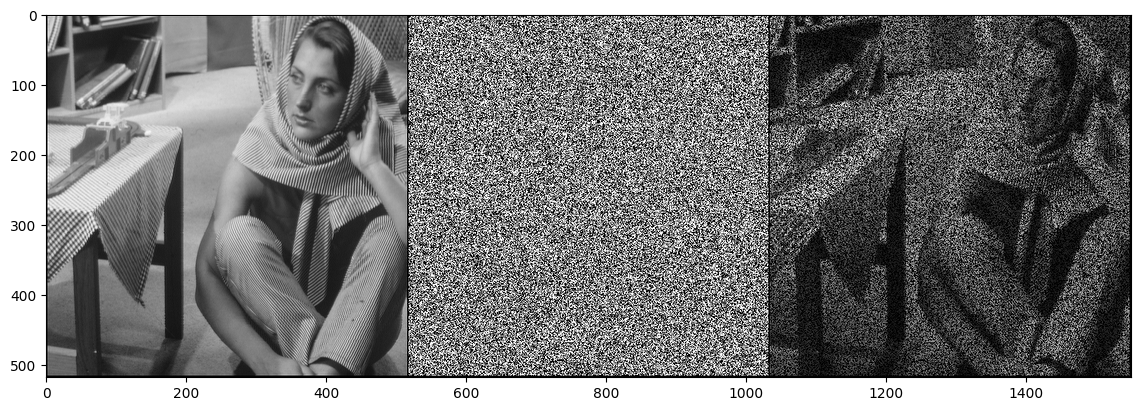

In [4]:
# fig. 7 (bottom)
f = '/content/drive/MyDrive/deep-image-prior/data/restoration/barbara.png'

# fig. 14 of supmat
# f = './data/restoration/kate.png'


img_pil, img_np = get_image(f, imsize)

if 'barbara' in f:
    img_np = nn.ReflectionPad2d(1)(np_to_torch(img_np))[0].numpy()
    img_pil = np_to_pil(img_np)

    img_mask = get_bernoulli_mask(img_pil, 0.50)
    img_mask_np = pil_to_np(img_mask)
elif 'kate' in f:
    img_mask = get_bernoulli_mask(img_pil, 0.98)

    img_mask_np = pil_to_np(img_mask)
    img_mask_np[1] = img_mask_np[0]
    img_mask_np[2] = img_mask_np[0]
else:
    assert False


img_masked = img_np * img_mask_np

mask_var = np_to_torch(img_mask_np).type(dtype)

plot_image_grid([img_np, img_mask_np, img_mask_np * img_np], 3,11);

# Set up everything

In [5]:
show_every=50
figsize=5
pad = 'reflection' # 'zero'
INPUT = 'noise'
input_depth = 32
OPTIMIZER = 'adam'
OPT_OVER =  'net'
if 'barbara' in f:
    OPTIMIZER = 'adam'

    LR = 0.001
    num_iter = 11000
    reg_noise_std = 0.03

    NET_TYPE = 'skip'
    net = get_net(input_depth, 'skip', pad, n_channels=1,
                  skip_n33d=128,
                  skip_n33u=128,
                  skip_n11=4,
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)
elif 'kate' in f:
    OPT_OVER = 'net'
    num_iter = 1000
    LR = 0.01
    reg_noise_std = 0.00

    net = skip(input_depth,
               img_np.shape[0],
               num_channels_down = [16, 32, 64, 128, 128],
               num_channels_up   = [16, 32, 64, 128, 128],
               num_channels_skip =    [0, 0, 0, 0, 0],
               filter_size_down = 3, filter_size_up = 3, filter_skip_size=1,
               upsample_mode='bilinear',
               downsample_mode='avg',
               need_sigmoid=True, need_bias=True, pad=pad).type(dtype)

# Loss
mse = torch.nn.MSELoss().type(dtype)
img_var = np_to_torch(img_np).type(dtype)

net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype).detach()

# Main loop

In [6]:
def closure():

    global i, psrn_masked_last, last_net, net_input

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = net(net_input)

    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()

    psrn_masked = compare_psnr(img_masked, out.detach().cpu().numpy()[0] * img_mask_np)
    psrn = compare_psnr(img_np, out.detach().cpu().numpy()[0])

    print ('Iteration %05d    Loss %f PSNR_masked %f PSNR %f' % (i, total_loss.item(), psrn_masked, psrn),'\r', end='')


    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)

        # Backtracking
        if psrn_masked - psrn_masked_last < -5:
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.cpu() for x in net.parameters()]
            psrn_masked_last = psrn_masked



        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)

    i += 1

    return total_loss

# Init globals
last_net = None
psrn_masked_last = 0
i = 0

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

# Run
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR=LR, num_iter=num_iter)

Output hidden; open in https://colab.research.google.com to view.

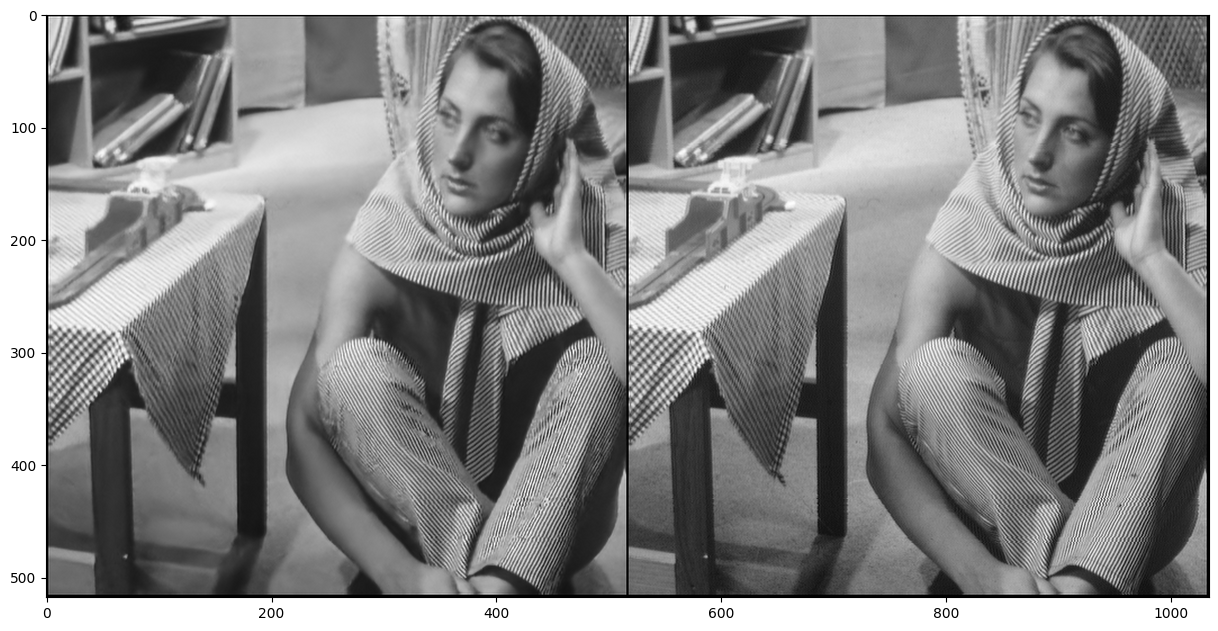

In [7]:
out_np = torch_to_np(net(net_input))
q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);